<a href="https://colab.research.google.com/github/verma-saloni/Thesis-Work/blob/main/politifact_ag_metapath2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%%capture
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install jsonlines

In [ ]:
import sys
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import jsonlines

from tqdm.auto import tqdm, trange

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

base_dir = Path("/gdrive/MyDrive/ResearchFND")

Mounted at /gdrive


In [ ]:
df = pd.read_csv(base_dir/"politifact_agg_2.csv")
df.head(5)

,title,text,tweets,retweets,label,url
0,Actress Emma Stone ‘For the first time in his...,NaN,[],"['1020554564334964741', '1020817527046197248',...",fake,NaN
1,Breaking President Trump makes English the of...,NaN,[],[],fake,NaN
2,Friendly Fire … Charlottesville Car attacker ...,NaN,[],"['3265439004', '3250621593', '3253922920', '32...",fake,NaN
3,If You Are Using This Toothpaste… Throw It Aw...,MightyLiving Blog\n\nHelpful inspiration from ...,"[{'id': 931006425966501893, 'text': 'If You Ar...","['911971426571255810', '1036749614853103616', ...",fake,mightynest.com/learn/research-by-concern/dange...
4,"""Face the Nation"" transcripts, August 26, 2012...","""Face the Nation"" transcripts, August 26, 2012...",[],[],real,https://web.archive.org/web/20120827001956/htt...


In [ ]:
df.describe()

,title,text,tweets,retweets,label,url
count,894,741,894,894,894,836
unique,894,703,172,677,2,836
top,Actress Emma Stone ‘For the first time in his...,About Trendolizer™\n\nTrendolizer™ (patent pen...,[],[],real,mightynest.com/learn/research-by-concern/dange...
freq,1,13,723,211,483,1


## User 2 user edges

In [ ]:
u2i = {}

follow_src = []
follow_dst = []
with jsonlines.open(base_dir/"followers.jsonl") as reader:
    for line in reader:
        v = line["user_id"]
        if v not in u2i:
            u2i[v] = len(u2i)
        for u in line["followers"]:
            if u not in u2i:
                u2i[u] = len(u2i)
            follow_src.append(u2i[u])
            follow_dst.append(u2i[v])

In [ ]:
with jsonlines.open(base_dir/"following.jsonl") as reader:
    for line in reader:
        u = line["user_id"]
        if u not in u2i:
            u2i[u] = len(u2i)
        for v in line["following"]:
            if v not in u2i:
                u2i[v] = len(u2i)
            follow_src.append(u2i[u])
            follow_dst.append(u2i[v])

## User 2 article

In [ ]:
import ast

In [ ]:
df['tweets'] = df.tweets.map(ast.literal_eval)

In [ ]:
users_tweeted = df.tweets.map(lambda x: [int(e['user_id']) for e in x])

In [ ]:
tweet_src = []
tweet_dst = []

for v, l in users_tweeted.iteritems():
    if not len(l):
        continue
    for u in l:
        if u not in u2i:
            u2i[u] = len(u2i)
        tweet_src.append(u2i[u])
        tweet_dst.append(v)

## Activity graph

In [ ]:
import torch
import torch_geometric as pyg
from torch_geometric.data import HeteroData

In [ ]:
import pickle

pickle.dump(u2i, open("u2i.pkl", "wb"))

In [ ]:
data = HeteroData()

data["article"].num_nodes = len(df)
data["user"].num_nodes = len(u2i)

In [ ]:
u2a_edges = torch.tensor([tweet_src, tweet_dst], dtype=torch.long)
u2u_edges = torch.tensor([follow_src, follow_dst], dtype=torch.long)

In [ ]:
data["user", "tweeted", "article"].edge_index = u2a_edges
data["article", "tweeted_by", "user"].edge_index = u2a_edges.flipud()

data["user", "follows", "user"].edge_index = u2u_edges
data["user", "followed_by", "user"].edge_index = u2u_edges.flipud()

In [ ]:
print(data)

HeteroData(
  article={ num_nodes=894 },
  user={ num_nodes=71759 },
  (user, tweeted, article)={ edge_index=[2, 62964] },
  (article, tweeted_by, user)={ edge_index=[2, 62964] },
  (user, follows, user)={ edge_index=[2, 48409] },
  (user, followed_by, user)={ edge_index=[2, 48409] }
)


# Training

In [ ]:
device = torch.device(device = 'cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
metapath = [
    ('user', 'follows', 'user'),
    ('user', 'tweeted', 'article'),
    ('article', 'tweeted_by', 'user'),
]

model = pyg.nn.MetaPath2Vec(
    data.edge_index_dict, 
    embedding_dim=128,
    metapath=metapath,
    walk_length=100, 
    context_size=7,
    walks_per_node=50,
    num_negative_samples=5,
    sparse=True
).to(device)

In [ ]:
loader = model.loader(batch_size=32, shuffle=True, num_workers=2)

In [ ]:
len(loader)

2243

In [ ]:
b = next(iter(loader))
b[0].shape

torch.Size([152000, 7])

In [ ]:
n_epoch = 5
lr = 5e-2

In [ ]:
optimizer = torch.optim.SparseAdam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1., end_factor=0., total_iters=n_epoch*len(loader))

In [ ]:
def train(epoch, log_steps=400):
    model.train()

    pbar = tqdm(loader)
    total_loss = 0
    for step, (pos_rw, neg_rw) in enumerate(pbar):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        if (step + 1) % log_steps == 0:
            print((f'Epoch: {epoch}, Step: {step + 1:03d}/{len(loader)}, '
                   f'Loss: {total_loss / log_steps:.4f}'))
            total_loss = 0

In [ ]:
for e in trange(1, n_epoch+1):

    train(e)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2243 [00:00<?, ?it/s]

Epoch: 1, Step: 400/2243, Loss: 0.9236
Epoch: 1, Step: 800/2243, Loss: 0.7942
Epoch: 1, Step: 1200/2243, Loss: 0.8166
Epoch: 1, Step: 1600/2243, Loss: 0.8070
Epoch: 1, Step: 2000/2243, Loss: 0.8102


  0%|          | 0/2243 [00:00<?, ?it/s]

Epoch: 2, Step: 400/2243, Loss: 0.9238
Epoch: 2, Step: 800/2243, Loss: 0.9928
Epoch: 2, Step: 1200/2243, Loss: 1.0451
Epoch: 2, Step: 1600/2243, Loss: 1.0945
Epoch: 2, Step: 2000/2243, Loss: 1.1481


  0%|          | 0/2243 [00:00<?, ?it/s]

Epoch: 3, Step: 400/2243, Loss: 1.1766
Epoch: 3, Step: 800/2243, Loss: 1.1613
Epoch: 3, Step: 1200/2243, Loss: 1.1545
Epoch: 3, Step: 1600/2243, Loss: 1.1469
Epoch: 3, Step: 2000/2243, Loss: 1.1391


  0%|          | 0/2243 [00:00<?, ?it/s]

Epoch: 4, Step: 400/2243, Loss: 1.1203
Epoch: 4, Step: 800/2243, Loss: 1.1088
Epoch: 4, Step: 1200/2243, Loss: 1.0995
Epoch: 4, Step: 1600/2243, Loss: 1.0937
Epoch: 4, Step: 2000/2243, Loss: 1.0889


  0%|          | 0/2243 [00:00<?, ?it/s]

Epoch: 5, Step: 400/2243, Loss: 1.0811
Epoch: 5, Step: 800/2243, Loss: 1.0769
Epoch: 5, Step: 1200/2243, Loss: 1.0751
Epoch: 5, Step: 1600/2243, Loss: 1.0725
Epoch: 5, Step: 2000/2243, Loss: 1.0729


In [ ]:
@torch.no_grad()
def get_embeddings(model, data, save_path=None):
    res = dict()
    for node_type in data.node_types:
        vecs = model(node_type).cpu().numpy()
        res[node_type] = vecs
        if save_path is not None:
            np.save(Path(save_path)/f"{node_type}_vectors.npy", vecs)
    return res

In [ ]:
embs = get_embeddings(model, data, './')

In [ ]:
embs["article"].shape, embs["user"].shape

((879, 128), (71759, 128))

In [ ]:
np.save(base_dir/'politifact_mp2vec_embeddings.npy', embs['article'])

# Visualization

In [ ]:
!pip install -qq umap-learn

     |████████████████████████████████| 88 kB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 21.0 MB/s 


In [ ]:
import umap

In [ ]:
article_vectors = embs["article"]

In [ ]:
reducer = umap.UMAP()

In [ ]:
emb2d = reducer.fit_transform(article_vectors)

In [ ]:
emb2d.shape

(879, 2)

In [ ]:
len(emb2d)

879

In [ ]:
x = emb2d
y = df['label'].to_numpy()[:len(emb2d)]
scale = (np.log2(df.tweets.map(len).to_numpy() + 1) + 1)* 20

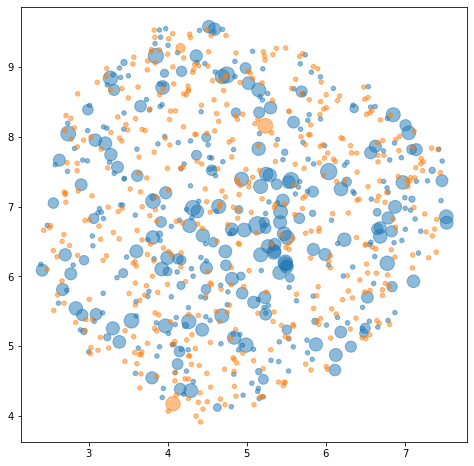

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
for lbl in np.unique(y):
    i = np.where(y == lbl)
    ax.scatter(x[i, 0], x[i, 1], label=lbl, alpha=0.5, s=scale[i])
plt.show()